# Benchmarking QSVC

We benchmark the QSVC algorithm by varying the number of qubits and layers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from jax_utils import square_kernel_matrix_jax, kernel_matrix_jax, target_alignment_jax
import pennylane.numpy as pnp
import pennylane as qml
import jax
import jax.numpy as jnp
import optax

from jax.config import config
config.update("jax_enable_x64", True)

seed = 42
np.random.seed(seed)
pnp.random.seed(seed)

jax.devices()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [2]:
train_df = pd.read_csv('./data/processed_train.csv')
test_df = pd.read_csv('./data/processed_test.csv')

In [3]:
target = 'manipulated'

In [4]:
X, y = train_df.drop(target, axis=1).to_numpy(), train_df[target].to_numpy()

y = 2*y -1

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=seed,
    stratify=y,
)

X_test, y_test = test_df.drop(target, axis=1).to_numpy(), test_df[target].to_numpy()
y_test = 2*y_test - 1

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(421, 3) (421,)
(181, 3) (181,)
(2170, 3) (2170,)


In [5]:
def feature_map(x, params, n_layers, n_wires):
    """The embedding ansatz"""
    steps = x.shape[0]//3
    qubits = list(range(n_wires))
    
    for q in qubits:
        qml.Hadamard(wires=q)
    
    for l in range(n_layers):
        for q in qubits:
            for i in range(steps):
                z = x[3*i:3*i+3]*params[l,q,0,3*i:3*i+3] + params[l,q,1,3*i:3*i+3]
                qml.Rot(z[0], z[1], z[2], wires=q)
                
        for i in range(n_wires - 1):
            qml.CZ((i, i + 1))

In [6]:
n_layers = [1,2,3,4]
n_wires = [1,2,3,4]

qsvc_dict = {
    'n_layers': [],
    'n_wires': [],
    'train_recall_score': [],
    'val_recall_score': [],
    'test_recall_score': [],
}

In [7]:
for l in n_layers:
    for q in n_wires:
        print(f"layer {l}, qubits {q}")
        
        params_shape = (l, q, 2, 3)
        params = pnp.random.uniform(0, 2 * np.pi, params_shape, requires_grad=True)
        dev = qml.device("default.qubit.jax", wires=q)
        
        @qml.qnode(dev, interface = 'jax')
        def kernel_circuit(x1, x2, params):
            feature_map(x1, params, l, q)
            qml.adjoint(feature_map)(x2, params, l, q)
            return qml.probs(wires=range(q))

        def kernel(x1, x2, params):
            return kernel_circuit(x1, x2, params)[0]
        
        jit_kernel = jax.jit(kernel)
        
            
        opt = optax.adam(learning_rate=0.05)
        opt_state = opt.init(params)

        for i in range(500):
            # Choose subset of datapoints to compute the KTA on.
            subset = np.random.choice(list(range(len(X_train))), 4)

            # Define the cost function for optimization
            cost = lambda _params: -target_alignment_jax(
                X_train[subset],
                y_train[subset],
                lambda x1, x2: jit_kernel(x1, x2, _params),
                assume_normalized_kernel=True,
            )

            # Optimization step
            grads = jax.grad(cost)(params)
            updates, opt_state = opt.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            # Report the alignment on the full dataset every 50 steps.
            if (i + 1) % 50 == 0:
                current_alignment = target_alignment_jax(
                    X_train,
                    y_train,
                    lambda x1, x2: jit_kernel(x1, x2, params),
                    assume_normalized_kernel=True,
                )
                print(f"Step {i+1} - Alignment = {current_alignment:.3f}")
        
        # First create a kernel with the trained parameter baked into it.
        trained_kernel = lambda x1, x2: jit_kernel(x1, x2, params)

        # Second create a kernel matrix function using the trained kernel.
        trained_kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, trained_kernel)

        # Note that SVC expects the kernel argument to be a kernel matrix function.
        qsvc_trained = SVC(probability=True, kernel=trained_kernel_matrix, random_state=seed)

        qsvc_trained.fit(X_train, y_train)
        
        train_preds = qsvc_trained.predict(X_train)
        val_preds = qsvc_trained.predict(X_val)
        test_preds = qsvc_trained.predict(X_test)
        
        out = classification_report(y_train, train_preds)
        print("Train Recall Score (trained parameters)")
        print('-'*50)
        print(out)
        
        train_recall_score = float(out.split('\n')[3].strip().split()[2])
        
        out = classification_report(y_val, val_preds)
        print("Val Recall Score (trained parameters)")
        print('-'*50)
        print(out)
        
        val_recall_score = float(out.split('\n')[3].strip().split()[2])
        
        out = classification_report(y_test, test_preds)
        print("Test Recall Score (trained parameters)")
        print('-'*50)
        print(out)
        
        test_recall_score = float(out.split('\n')[3].strip().split()[2])

        qsvc_dict['n_layers'].append(l)
        qsvc_dict['n_wires'].append(q)
        qsvc_dict['train_recall_score'].append(train_recall_score)
        qsvc_dict['val_recall_score'].append(train_recall_score)
        qsvc_dict['test_recall_score'].append(test_recall_score)
        
        pd.DataFrame(qsvc_dict).to_csv('qsvc_trained.csv')

layer 1, qubits 1
Step 50 - Alignment = 0.045
Step 100 - Alignment = 0.008
Step 150 - Alignment = 0.048
Step 200 - Alignment = 0.058
Step 250 - Alignment = 0.021
Step 300 - Alignment = 0.004
Step 350 - Alignment = 0.004
Step 400 - Alignment = 0.035
Step 450 - Alignment = 0.044
Step 500 - Alignment = 0.057
Train Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.68      0.68      0.68       210
           1       0.68      0.68      0.68       211

    accuracy                           0.68       421
   macro avg       0.68      0.68      0.68       421
weighted avg       0.68      0.68      0.68       421

Val Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.61      0.57      0.59        91
           1       0.59      0.63      0.61        90

    accuracy          

Step 50 - Alignment = 0.144
Step 100 - Alignment = 0.152
Step 150 - Alignment = 0.128
Step 200 - Alignment = 0.150
Step 250 - Alignment = 0.092
Step 300 - Alignment = 0.131
Step 350 - Alignment = 0.152
Step 400 - Alignment = 0.170
Step 450 - Alignment = 0.141
Step 500 - Alignment = 0.169
Train Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.92      0.94       210
           1       0.93      0.96      0.94       211

    accuracy                           0.94       421
   macro avg       0.94      0.94      0.94       421
weighted avg       0.94      0.94      0.94       421

Val Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.88      0.91        91
           1       0.89      0.94      0.91        90

    accuracy                           0

Step 50 - Alignment = 0.002
Step 100 - Alignment = 0.034
Step 150 - Alignment = 0.012
Step 200 - Alignment = 0.072
Step 250 - Alignment = 0.024
Step 300 - Alignment = 0.076
Step 350 - Alignment = 0.009
Step 400 - Alignment = 0.066
Step 450 - Alignment = 0.086
Step 500 - Alignment = 0.053
Train Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.68      0.64      0.66       210
           1       0.66      0.69      0.68       211

    accuracy                           0.67       421
   macro avg       0.67      0.67      0.67       421
weighted avg       0.67      0.67      0.67       421

Val Recall Score (trained parameters)
--------------------------------------------------
              precision    recall  f1-score   support

          -1       0.60      0.57      0.59        91
           1       0.59      0.62      0.61        90

    accuracy                           0

In [8]:
df = pd.read_csv('qsvc_trained.csv')
df

,Unnamed: 0,n_layers,n_wires,train_recall_score,val_recall_score,test_recall_score
0,0,1,1,0.68,0.68,0.64
1,1,1,2,1.00,1.00,1.00
2,2,1,3,0.96,0.96,0.96
3,3,1,4,1.00,1.00,0.96
4,4,2,1,0.74,0.74,0.68
5,5,2,2,0.94,0.94,0.96
6,6,2,3,0.96,0.96,0.93
7,7,2,4,0.98,0.98,0.96
8,8,3,1,0.66,0.66,0.64
9,9,3,2,0.90,0.90,0.86


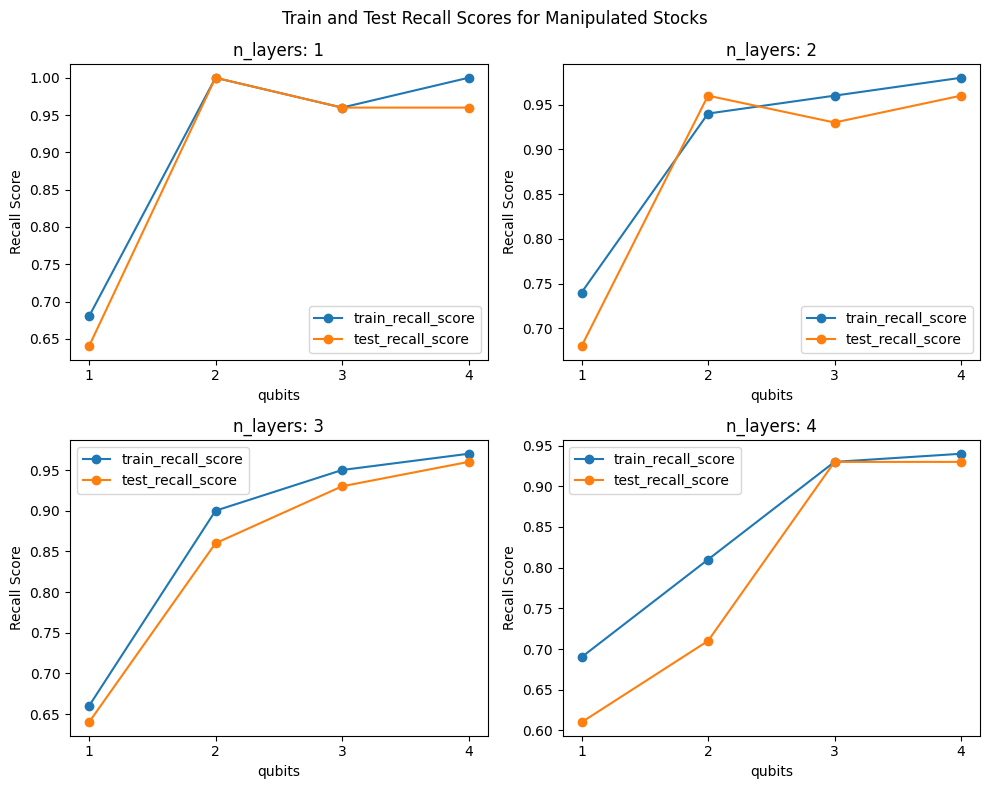

In [9]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

for i in range(2):
    for j in range(2):
        n_l = i*2 + j + 1
        df[df['n_layers'] == n_l].plot(kind = 'line', 
                                     x = 'n_wires', 
                                     y = 'train_recall_score', 
                                     marker = 'o', 
                                     ax = axs[i, j])
        
#         df[df['n_layers'] == n_l].plot(kind = 'line', 
#                                      x = 'n_wires', 
#                                      y = 'val_recall_score', 
#                                      marker = 'o', 
#                                      ax = axs[i, j])
        
        df[df['n_layers'] == n_l].plot(kind = 'line', 
                                     x = 'n_wires', 
                                     y = 'test_recall_score', 
                                     marker = 'o', 
                                     ax = axs[i, j])
        axs[i, j].set_title(f"n_layers: {n_l}")

for ax in axs.flat:
    ax.set(xlabel='qubits', ylabel='Recall Score')
    ax.set_xticks([1,2,3,4])
#     ax.label_outer()
    
fig.suptitle('Train and Test Recall Scores for Manipulated Stocks')
fig.tight_layout()

## Inference

It is evident that as the number of qubits increase (so is the number of trainable parameters), the train/test score increases. For a fixed layer, the scores seem to saturate with 3 and 4 qubits (although, we need to perform more rigorous testing).